In [1]:
import os
from openmm import Platform, LangevinMiddleIntegrator, XmlSerializer
import openmm.app as app
from openmm.unit import picosecond, kelvin
import parmed
import MDAnalysis as md
from MDAnalysis.analysis import dihedrals
import nglview as ng
import numpy as np
import matplotlib.pyplot as plt
import sys
from pdbfixer import PDBFixer

In [2]:
data_path = 'data/1ytc'
rslt_path = 'data/1ytc/rslt_openmm'
file_name = '1ytc.pdb'
fixed_file_name = '1ytc_fixed.pdb'

In [3]:
# use pdbfixer to fix pdb
# https://htmlpreview.github.io/?https://github.com/openmm/pdbfixer/blob/master/Manual.html
fixer = PDBFixer(filename=os.path.join(data_path, file_name))
fixer.findMissingResidues()
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
fixer.removeHeterogens(True)
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(7.0)
app.PDBFile.writeFile(fixer.topology, fixer.positions, open(os.path.join(data_path, fixed_file_name), 'w'))

In [4]:
# Input and options
pdbfile = fixed_file_name
psffile = '1ytc_fixed.psf'
pdb = app.PDBFile(os.path.join(data_path, pdbfile))
print(pdb.topology)

# 感觉用 amber14/protein.ff14SB.xml 似乎会更好
# 但实际上看过 amber14-all 就知道它包含了 amber14/protein.ff14SB.xml
# forcefield = app.ForceField('amber14-all.xml')
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

nonbondedMethod = app.NoCutoff
constraints = None
rigidWater = False

dt = 0.002*picosecond
temperature = 300.15*kelvin
friction = 1/picosecond

steps = 50000
logInterval = 100
platform = Platform.getPlatformByName('OpenCL')
# platform = Platform.getPlatformByName('CPU')
# platformProperties = {'Precision': 'mixed'} # use this for CUDA
platformProperties = dict() # use this for CPU

<Topology; 2 chains, 228 residues, 2098 atoms, 2000 bonds>


In [5]:
# Prepare the Simulation
print('Building system...')
topology = pdb.topology
print(topology.getPeriodicBoxVectors())
positions = pdb.positions
system = forcefield.createSystem(topology, nonbondedMethod=nonbondedMethod, constraints=constraints, rigidWater=rigidWater)
print(system.getDefaultPeriodicBoxVectors())
print(system.getForce(0))
print(system.getForce(1))
print(system.getForce(2))
print(dir(system.getForce(0)))
print(system.getForce(0).getBondParameters(0))

# modified by jk
# from openmm import unit
# edge = 1e20 * unit.nanometers
# system.setDefaultPeriodicBoxVectors([edge,0,0], [0,edge,0], [0,0,edge])
# print(system.getDefaultPeriodicBoxVectors())

# save the system
integrator = LangevinMiddleIntegrator(temperature, friction, dt)
simulation = app.Simulation(topology, system, integrator, platform, platformProperties)
# save the topology and the contex
simulation.context.setPositions(positions)
simulation.context.setVelocitiesToTemperature(temperature, 2023)

# save psf file for future visualization
parmed_structure = parmed.openmm.load_topology(topology, system, positions)
parmed_structure.save(os.path.join(data_path, psffile), overwrite=True)

Building system...
(Vec3(x=3.666, y=0.0, z=0.0), Vec3(x=0.0, y=3.666, z=0.0), Vec3(x=0.0, y=0.0, z=13.892)) nm
[Quantity(value=Vec3(x=3.666, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=3.666, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=13.892), unit=nanometer)]
<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x13f908450> >
<openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x13f9083f0> >
<openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x13f908420> >
['__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__'

In [6]:
with open(os.path.join(rslt_path, 'state_before_min.xml'), 'w') as f:
    f.write(
        XmlSerializer.serialize(
            simulation.context.getState(getPositions=True,
                                        getVelocities=True,
                                        getForces=True,
                                        getEnergy=True,
                                        getParameters=True,
                                        getParameterDerivatives=True,
                                        getIntegratorParameters=True,
                                        enforcePeriodicBox=True)))

In [7]:
# Minimize
print("\nInitial system energy")
print(simulation.context.getState(getEnergy=True).getPotentialEnergy())
print('Performing energy minimization...')
simulation.minimizeEnergy()
print("\nMinimized system energy")
print(simulation.context.getState(getEnergy=True).getPotentialEnergy())


Initial system energy
53381.140625 kJ/mol
Performing energy minimization...

Minimized system energy
-15146.248046875 kJ/mol


In [8]:
# save file for future use
with open(os.path.join(rslt_path, 'system.xml'), 'w') as f:
    f.write(XmlSerializer.serialize(system))
with open(os.path.join(rslt_path, 'state.xml'), 'w') as f:
    f.write(XmlSerializer.serialize(
            simulation.context.getState(
            getPositions=True, getVelocities=True, getForces=True, 
            getEnergy=True, getParameters=True, getParameterDerivatives=True, 
            getIntegratorParameters=True, enforcePeriodicBox=True)))

In [9]:
# topology from pdbfile, system and state from xml
# use the following code to load simulation to run

# integrator = LangevinMiddleIntegrator(temperature, friction, dt)
# system = XmlSerializer.deserialize(open('system.xml').read())
# simulation = app.Simulation(topology, system, integrator, platform, platformProperties)
# simulation.context.setState(XmlSerializer.deserialize(open('state.xml').read()))

In [10]:
print('Simulating...')
simulation.currentStep = 0
dcdReporter = app.DCDReporter(os.path.join(rslt_path, 'traj-nocutoff.dcd'), logInterval)
dataReporter = app.StateDataReporter(os.path.join(rslt_path, 'traj-nocutoff.log'), logInterval, totalSteps=steps,
    step=True, time=True, speed=True, progress=True, elapsedTime=True, remainingTime=True, potentialEnergy=True, temperature=True, separator='\t')
stdoutReporter = app.StateDataReporter(sys.stdout, logInterval*10, totalSteps=steps,
    step=True, time=True, speed=True, progress=True, elapsedTime=True, remainingTime=True, potentialEnergy=True, temperature=True, separator='\t')
simulation.reporters.append(dataReporter)
simulation.reporters.append(stdoutReporter)
simulation.reporters.append(dcdReporter)
simulation.step(steps)

# Write file with final simulation state
simulation.saveState(os.path.join(rslt_path, 'final_state_nocutoff.xml'))

Simulating...
#"Progress (%)"	"Step"	"Time (ps)"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Elapsed Time (s)"	"Time Remaining"
2.0%	1000	2.0000000000000013	-6782.6923828125	333.9746311822155	0	8.20159912109375e-05	--
4.0%	2000	3.999999999999781	-7976.087890625	311.69781232280013	339	0.5103960037231445	0:24
6.0%	3000	5.999999999999561	-8083.98974609375	313.0912197618439	340	1.0170090198516846	0:23
8.0%	4000	7.999999999999341	-8272.49609375	301.81470946312595	340	1.5263168811798096	0:23
10.0%	5000	10.000000000000009	-8292.6708984375	303.80316184968495	339	2.0373940467834473	0:22
12.0%	6000	12.000000000000677	-8742.4384765625	298.24736147604574	340	2.54229998588562	0:22
14.0%	7000	14.000000000001345	-8903.142578125	301.2793753496843	340	3.0454938411712646	0:21
16.0%	8000	16.00000000000201	-8659.43359375	298.4895612423372	341	3.547926902770996	0:21
18.0%	9000	18.000000000000902	-8466.4453125	300.620043799954	341	4.053887128829956	0:20
20.0%	10000	19.999999999999794	-8

In [11]:
u = md.Universe(os.path.join(data_path, psffile), os.path.join(rslt_path, 'traj-nocutoff.dcd'))
ng.show_mdanalysis(u, gui=True)

NGLWidget(max_frame=499)

/Users/jerrykwan/anaconda3/envs/temp/lib/python3.9/site-packages/MDAnalysis/analysis/dihedrals.py:422: UserWarning: Cannot determine phi and psi angles for the first or last residues
  warnings.warn("Cannot determine phi and psi angles for the first "


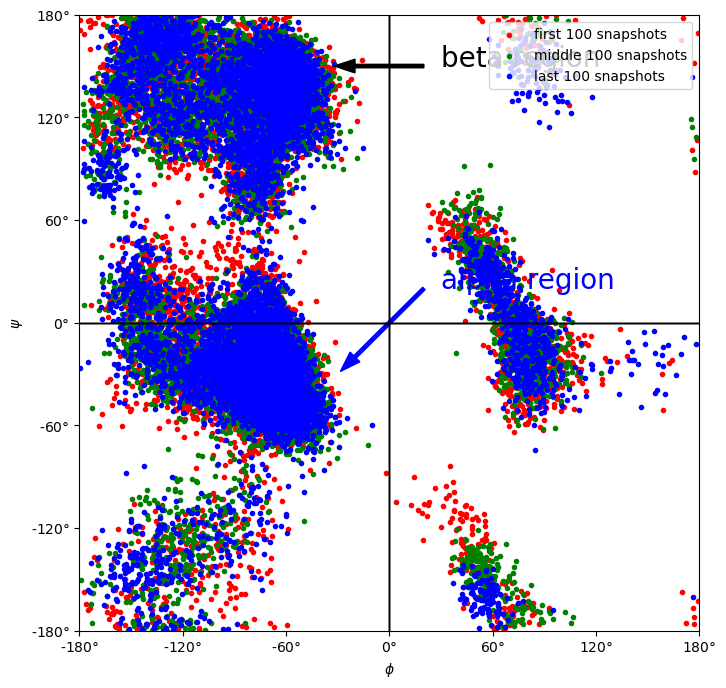

In [12]:
u = u.select_atoms('not resname HOH')
ram1 = dihedrals.Ramachandran(u).run(0, 100) 
ram_mid = dihedrals.Ramachandran(u).run(200, 300)
ram2 = dihedrals.Ramachandran(u).run(400, 500)  # maybe not include the last snapshot

# ramachandran plot
fig, ax = plt.subplots(figsize=(8,8))
ram1.plot(ax=ax, color='r', marker='.', label='first 100 snapshots')
ram_mid.plot(ax=ax, color='g', marker='.', label='middle 100 snapshots')
ram2.plot(ax=ax, color='b', marker='.', label='last 100 snapshots')
ax.arrow(20, 20, -40, -40, width=2, head_width=8, head_length=12, fc='b', ec='b')
ax.text(30, 20, 'alpha region', color='blue', fontsize=20)
ax.arrow(20, 150, -40, 0, width=2, head_width=8, head_length=12, fc='k', ec='k')
ax.text(30, 150, 'beta region', fontsize=20)
plt.legend()
plt.show()